# Solving CartPole with n-Step SARSA

# Imports/Hyperparameters

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
import random
import matplotlib.pyplot as plt

# Hyperparams
ENV_NAME = "CartPole-v1"
N_EPISODES = 5000
N_STEPS = 8
GAMMA = 0.99
LR = 1e-3
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 0.995
BATCH_SIZE = 64
MEMORY_SIZE = 100000

# Buffer + *Q* Approximation 

In [2]:
Transition = namedtuple('Transition', ('state','action','reward','next_state','done'))

# Replay buffer with fixed capacity
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# Q network
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.net(x)

# Train

In [3]:
def select_action(q_net, state, eps):
    if random.random() < eps:
        return random.randrange(2)
    with torch.no_grad():
        return q_net(state).argmax().item()

buffer = ReplayBuffer(MEMORY_SIZE)
env = gym.make(ENV_NAME)

policy_net = QNetwork(env.observation_space.shape[0], env.action_space.n)
optimizer = optim.Adam(policy_net.parameters(), lr=LR)

episode_returns = []
eps = EPS_START

for ep in range(N_EPISODES):
    state, _ = env.reset()
    done = False
    ep_return = 0

    # n-step storage
    states, actions, rewards = [state], [], [0.0]
    T = float('inf')
    t = 0

    action = select_action(policy_net, torch.FloatTensor(state), eps)
    actions.append(action)

    while True:
        if t < T:
            next_state, reward, terminated, truncated, _ = env.step(action)
            rewards.append(reward)
            states.append(next_state)
            ep_return += reward

            if terminated or truncated:
                T = t + 1
            else:
                action = select_action(policy_net, torch.FloatTensor(next_state), eps)
                actions.append(action)

        tau = t - N_STEPS + 1
        if tau >= 0:
            G = 0.0
            for i in range(tau+1, min(tau+N_STEPS, T)+1):
                G += (GAMMA**(i-tau-1))*rewards[i]

            # Add bootstrap if not terminal
            if tau + N_STEPS < T:
                s_tp = torch.FloatTensor(states[tau+N_STEPS])
                with torch.no_grad():
                    G += (GAMMA**N_STEPS)*policy_net(s_tp).max().item()

            buffer.push(
                states[tau],
                actions[tau],
                G,
                states[tau+N_STEPS] if (tau+N_STEPS < len(states)) else np.zeros_like(state),
                1 if (tau+N_STEPS >= T) else 0
            )

        if tau == T - 1:
            break
        t += 1

        # batch update
        if len(buffer) >= BATCH_SIZE:
            batch = buffer.sample(BATCH_SIZE)
            batch = Transition(*zip(*batch))

            # convert to numpy arrays first
            s_arr = np.array(batch.state)
            ns_arr = np.array(batch.next_state)

            states_b = torch.FloatTensor(s_arr)
            next_states_b = torch.FloatTensor(ns_arr)
            actions_b = torch.LongTensor(batch.action).unsqueeze(1)
            rewards_b = torch.FloatTensor(batch.reward)
            dones_b = torch.FloatTensor(batch.done)

            q_vals = policy_net(states_b).gather(1, actions_b).squeeze()
            with torch.no_grad():
                next_q_vals = policy_net(next_states_b).max(1)[0]
                targets = rewards_b + (GAMMA * next_q_vals * (1 - dones_b))

            loss = nn.MSELoss()(q_vals, targets)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)  # gradient clipping
            optimizer.step()

    eps = max(EPS_END, eps*EPS_DECAY)
    episode_returns.append(ep_return)

    if (ep+1) % 500 == 0:
        print(f"Episode {ep+1} Return {ep_return:.2f} Epsilon {eps:.3f}")

plt.plot(episode_returns)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.show()

env.close()

Episode 500 Return 8.00 Epsilon 0.082
Episode 1000 Return 10.00 Epsilon 0.010
Episode 1500 Return 9.00 Epsilon 0.010
Episode 2000 Return 12.00 Epsilon 0.010
Episode 2500 Return 12.00 Epsilon 0.010
Episode 3000 Return 10.00 Epsilon 0.010
Episode 3500 Return 10.00 Epsilon 0.010
Episode 4000 Return 11.00 Epsilon 0.010
Episode 4500 Return 11.00 Epsilon 0.010
Episode 5000 Return 10.00 Epsilon 0.010


: 

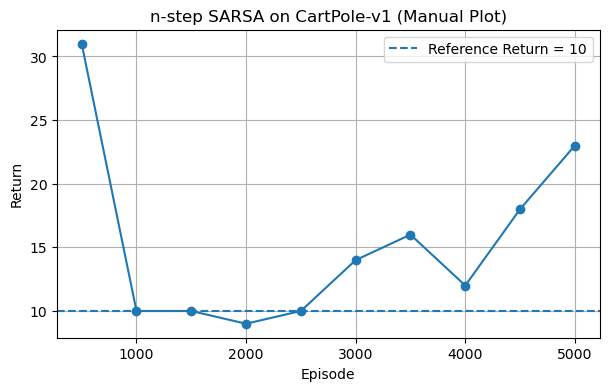

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Episode checkpoints and corresponding returns (from your log)
episodes = np.array([500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000])
returns  = np.array([31,   10,   10,    9,    10,   14,   16,   12,   18,   23])

plt.figure(figsize=(7,4))
plt.plot(episodes, returns, marker='o')
plt.axhline(y=10, linestyle='--', label='Reference Return = 10')

plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("n-step SARSA on CartPole-v1 (Manual Plot)")
plt.legend()
plt.grid(True)
plt.show()